In [1]:
import pandas as pd
import numpy as np
import math
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
#Function to return Minimum and Maximum value of a state feature
def min_max_states(non_null_values_col, non_null_values_col_nx):
    return min(non_null_values_col.min(),non_null_values_col_nx.min()), max(non_null_values_col.max(),non_null_values_col_nx.max())

In [4]:
def dataToDiscretisedMDP(sample_data_file, json_file, output_file):
    df_data = pd.read_excel(sample_data_file)
    df_json = pd.read_json(json_file) #Write in sep func
    state_var = []
    nx_state_var = []
    for i, row in df_json.iterrows():
        col_name = row['column_name']
        col_name_nx = 'nx_' + col_name
        non_null_values_col, non_null_values_col_nx = df_data[col_name].dropna(), df_data[col_name_nx].dropna()
        state_var.append(col_name)
        nx_state_var.append(col_name_nx)
    
        if row['no_of_bins'] is not None and not math.isnan(row['no_of_bins']):
            bins = int(row['no_of_bins'])
            min_value, max_value = min_max_states(non_null_values_col, non_null_values_col_nx)
            bin_size = (max_value - min_value) / bins
            bin = [min_value + i * bin_size for i in range(bins + 1)]
            df_data[col_name] = pd.cut(non_null_values_col, bins=bins, labels=False) + 1
            df_data[col_name_nx] = pd.cut(non_null_values_col_nx, bins=bins, labels=False) + 1
    
        elif row['bin_size'] is not None and not math.isnan(row['bin_size']):
            bin_size = row['bin_size']
            min_value, max_value = min_max_states(non_null_values_col, non_null_values_col_nx)
            bin = [min_value + i * bin_size for i in range(bins + 1)]
            df_data[col_name] = pd.cut(non_null_values_col, bins=bins, labels=False) + 1
            df_data[col_name_nx] = pd.cut(non_null_values_col_nx, bins=bins, labels=False) + 1
    
        elif len(row['bin_list'])>0:
            bin_list = row['bin_list']
            if isinstance(bin_list, list):
                bin_list = [interval for interval in bin_list if all(not math.isnan(value) for value in interval)]
            if bin_list:
                bin_intervals = [interval[0] for interval in bin_list] + [bin_list[-1][-1]]
                df_data[col_name] = pd.cut(non_null_values_col, bins=bins, labels=False) + 1
                df_data[col_name_nx] = pd.cut(non_null_values_col_nx, bins=bins, labels=False) + 1
    #Doing the same with comma delimiter
    df_discrete = pd.DataFrame(df_data['action'])
    df_discrete['current_state'] = df_data.loc[:, state_var].apply(lambda row: ', '.join(map(str, row)), axis=1)
    df_discrete['next_state'] = df_data.loc[:, nx_state_var].apply(lambda row: ', '.join(map(str, row)), axis=1)
    #df['action'] = 
    #df_mdp = pd.DataFrame(df_data[state_var + ['action'] + nx_state_var])
    #print(df_discrete.head())
    
    #Discretized Sample to MDP
    df_empirical_probs = df_discrete.groupby(['current_state', 'action', 'next_state']).size().reset_index(name='count')
    #print(df_empirical_probs)
    df_empirical_count = df_discrete.groupby(['current_state', 'action']).size().reset_index(name='count_total')
    #print(df_empirical_count)

    df_empirical_probs = df_empirical_probs.merge(df_empirical_count, on=['current_state', 'action'])
    df_empirical_probs['probability'] = df_empirical_probs['count'] / df_empirical_probs['count_total']
    #print(df_empirical_probs)
    df_empirical_probs[['current_state', 'action', 'next_state', 'probability']].to_excel(output_file, index=False)
    
    #Display the MDP
    mdp_graph = nx.DiGraph()

    # Add states as nodes to the graph
    for index, row in df_empirical_probs.iterrows():
        state = row['current_state']  
        mdp_graph.add_node(state)

    # Add transitions as edges to the graph
    for index, row in df_empirical_probs.iterrows():
        state = row['current_state']  
        action = row['action']
        next_state = row['next_state']  
        transition_prob = row['probability'] 
        mdp_graph.add_edge(state, next_state, action=action, probability=transition_prob)

    # Plot the MDP graph
    pos = nx.spring_layout(mdp_graph)  # You can use different layout algorithms
    nx.draw_networkx(mdp_graph, pos=pos, with_labels=True)

    # Add edge labels
    edge_labels = nx.get_edge_attributes(mdp_graph, 'probability')
    nx.draw_networkx_edge_labels(mdp_graph, pos=pos, edge_labels=edge_labels)

    # Show the plot
    plt.show()


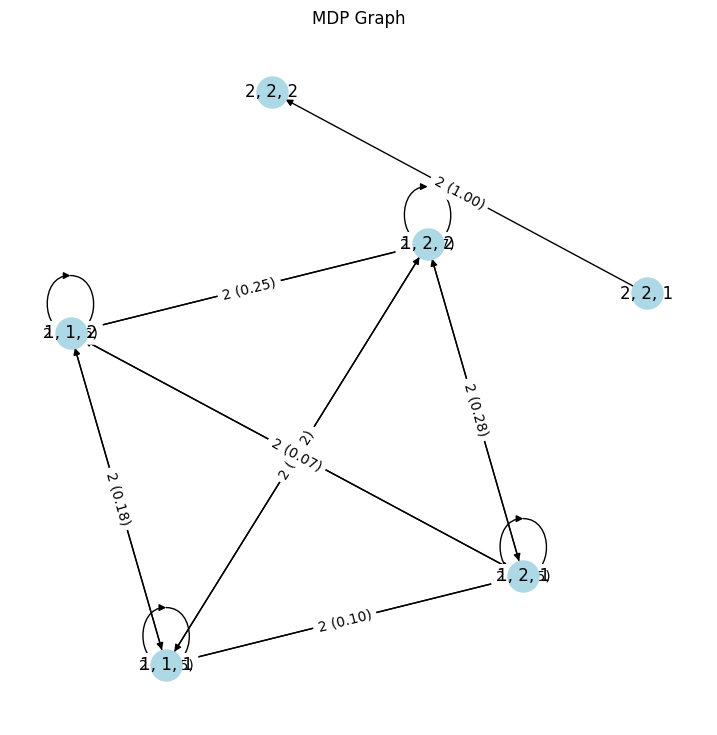

In [10]:
#dataToDiscretisedMDP('dataformdp.xlsm', 'discrete1.json', 'mdpfile1.xlsm')
#visualisation in sep func
#Define a class MDP init, visualise, construct, json
#implement abstraction with a weight function
#Do separately for graphviz a
#for i in range(1,7):
    #dataToDiscretisedMDP('dataformdp.xlsm', 'discrete' + str(i) + '.json', 'mdpfile' + str(i) + '.xlsm')
dataToDiscretisedMDP('dataformdp.xlsm', 'discrete' + str(1) + '.json', 'mdpfile' + str(1) + '.xlsm')

In [6]:
def dataToDiscretisedMDP(sample_data_file, json_file, output_file):
    df_data = pd.read_excel(sample_data_file)
    df_json = pd.read_json(json_file)
    state_var = []
    nx_state_var = []
    for i, row in df_json.iterrows():
        col_name = row['column_name']
        col_name_nx = 'nx_' + col_name
        non_null_values_col, non_null_values_col_nx = df_data[col_name].dropna(), df_data[col_name_nx].dropna()
        state_var.append(col_name)
        nx_state_var.append(col_name_nx)
    
        if row['no_of_bins'] is not None and not math.isnan(row['no_of_bins']):
            bins = int(row['no_of_bins'])
            min_value, max_value = min_max_states(non_null_values_col, non_null_values_col_nx)
            bin_size = (max_value - min_value) / bins
            bin = [min_value + i * bin_size for i in range(bins + 1)]
            df_data[col_name] = pd.cut(non_null_values_col, bins=bins, labels=False) + 1
            df_data[col_name_nx] = pd.cut(non_null_values_col_nx, bins=bins, labels=False) + 1
    
        elif row['bin_size'] is not None and not math.isnan(row['bin_size']):
            bin_size = row['bin_size']
            min_value, max_value = min_max_states(non_null_values_col, non_null_values_col_nx)
            bin = [min_value + i * bin_size for i in range(bins + 1)]
            df_data[col_name] = pd.cut(non_null_values_col, bins=bins, labels=False) + 1
            df_data[col_name_nx] = pd.cut(non_null_values_col_nx, bins=bins, labels=False) + 1
    
        elif len(row['bin_list'])>0:
            bin_list = row['bin_list']
            if isinstance(bin_list, list):
                bin_list = [interval for interval in bin_list if all(not math.isnan(value) for value in interval)]
            if bin_list:
                bin_intervals = [interval[0] for interval in bin_list] + [bin_list[-1][-1]]
                df_data[col_name] = pd.cut(non_null_values_col, bins=bins, labels=False) + 1
                df_data[col_name_nx] = pd.cut(non_null_values_col_nx, bins=bins, labels=False) + 1
    #Doing the same with comma delimiter
    df_discrete = pd.DataFrame(df_data['action'])
    df_discrete['current_state'] = df_data.loc[:, state_var].apply(lambda row: ', '.join(map(str, row)), axis=1)
    df_discrete['next_state'] = df_data.loc[:, nx_state_var].apply(lambda row: ', '.join(map(str, row)), axis=1)
    #df['action'] = 
    #df_mdp = pd.DataFrame(df_data[state_var + ['action'] + nx_state_var])
    #print(df_discrete.head())
    
    #Discretized Sample to MDP
    df_empirical_probs = df_discrete.groupby(['current_state', 'action', 'next_state']).size().reset_index(name='count')
    #print(df_empirical_probs)
    df_empirical_count = df_discrete.groupby(['current_state', 'action']).size().reset_index(name='count_total')
    #print(df_empirical_count)

    df_empirical_probs = df_empirical_probs.merge(df_empirical_count, on=['current_state', 'action'])
    df_empirical_probs['probability'] = df_empirical_probs['count'] / df_empirical_probs['count_total']
    #print(df_empirical_probs)
    df_empirical_probs[['current_state', 'action', 'next_state', 'probability']].to_excel(output_file, index=False)
    
    #Display the MDP
    mdp_graph = nx.DiGraph()
    
    states = set(df_empirical_probs['current_state']) | set(df_empirical_probs['next_state'])

    # Add states as nodes to the graph
    for state in states: 
        mdp_graph.add_node(state)

    # Add transitions as edges to the graph
    for index, row in df_empirical_probs.iterrows():
        state = row['current_state']  
        action = row['action']
        next_state = row['next_state']  
        probability = format(row['probability'],".2f") 
        mdp_graph.add_edge(state, next_state, label=f'{action} ({probability})')

    # Plot the MDP graph
    pos = nx.kamada_kawai_layout(mdp_graph)
    labels = nx.get_edge_attributes(mdp_graph, 'label')
    plt.figure(figsize=(9, 9))  # Adjust figure size as needed
    nx.draw_networkx(mdp_graph, pos, with_labels=True, node_size=500, node_color='lightblue')
    nx.draw_networkx_edge_labels(mdp_graph, pos, edge_labels=labels)
    plt.title("MDP Graph")
    plt.axis('off')
    plt.show()


In [1]:
import pandas as pd
import numpy as np
import math
import networkx as nx
import matplotlib.pyplot as plt
import os
from PIL import Image
import graphviz

In [4]:
class MDP:
    def __init__(self, sampleFile):
        self.df_data = pd.read_excel(sampleFile)
        self.df_discrete = None
    
    def discretize(self, jsonFile):
        df_json = pd.read_json(jsonFile)
        self.state_var = []
        self.nx_state_var = []
        self.state_bin_var = []
        self.nx_state_bin_var = []
        
        for i, row in df_json.iterrows():
            col_name, col_name_nx, col_name_bins, col_name_bins_nx = self.naming_state_col(row['column_name'])
            non_null_values_col, non_null_values_col_nx = self.df_data[col_name].dropna(), self.df_data[col_name_nx].dropna()
            self.state_var.append(col_name)
            self.nx_state_var.append(col_name_nx)
            self.state_bin_var.append(col_name_bins)
            self.nx_state_bin_var.append(col_name_bins_nx)

            if row['no_of_bins'] is not None and not math.isnan(row['no_of_bins']):
                bins = int(row['no_of_bins'])
                min_value, max_value = self.min_max_states(non_null_values_col, non_null_values_col_nx)
                bin_size = (max_value - min_value) / bins
                bin = [min_value + i * bin_size for i in range(bins + 1)]
                self.df_data[col_name_bins] = pd.cut(non_null_values_col, bins=bins, labels=False) + 1
                self.df_data[col_name_bins_nx] = pd.cut(non_null_values_col_nx, bins=bins, labels=False) + 1

            elif row['bin_size'] is not None and not math.isnan(row['bin_size']):
                bin_size = row['bin_size']
                min_value, max_value = self.min_max_states(non_null_values_col, non_null_values_col_nx)
                bin = [min_value + i * bin_size for i in range(bins + 1)]
                self.df_data[col_name_bins] = pd.cut(non_null_values_col, bins=bins, labels=False) + 1
                self.df_data[col_name_bins_nx] = pd.cut(non_null_values_col_nx, bins=bins, labels=False) + 1

            elif len(row['bin_list'])>0:
                bin_list = row['bin_list']
                if isinstance(bin_list, list):
                    bin_list = [interval for interval in bin_list if all(not math.isnan(value) for value in interval)]
                if bin_list:
                    bin_intervals = [interval[0] for interval in bin_list] + [bin_list[-1][-1]]
                    self.df_data[col_name_bins] = pd.cut(non_null_values_col, bins=bins, labels=False) + 1
                    self.df_data[col_name_bins_nx] = pd.cut(non_null_values_col_nx, bins=bins, labels=False) + 1
                    
        self.df_data['current_state'] = self.df_data.loc[:, self.state_var].apply(lambda row: ', '.join(map(str, row)), axis=1)
        self.df_data['next_state'] = self.df_data.loc[:, self.nx_state_var].apply(lambda row: ', '.join(map(str, row)), axis=1)
        
        self.df_data['current_state_bin'] = self.df_data.loc[:, self.state_bin_var].apply(lambda row: ', '.join(map(str, row)), axis=1)
        self.df_data['next_state_bin'] = self.df_data.loc[:, self.nx_state_bin_var].apply(lambda row: ', '.join(map(str, row)), axis=1)
           
        self.df_data = self.df_data[['current_state','next_state','current_state_bin','next_state_bin','action','reward']]
        self.abstract_curr = self.df_data[['current_state','current_state_bin']].drop_duplicates().rename(columns={'current_state_bin' : 'state_bin','current_state' : 'state'})
        self.abstract_next = self.df_data[['next_state','next_state_bin']].drop_duplicates().rename(columns={'next_state_bin' : 'state_bin','next_state' : 'state'})
        self.abstract = self.abstract_curr.append(self.abstract_next, ignore_index=True).drop_duplicates()
        new_column_names = {'current_state_bin' : 'current_state' , 'next_state_bin' : 'next_state'}
        self.df_discrete = pd.DataFrame(self.df_data[['current_state_bin','next_state_bin','action','reward']].rename(columns=new_column_names))
        #print(self.df_discrete.columns)
    
    #Constructs MDP from the discretised features
    def constructMDPfromDiscreteFeature(self, output_file = None):
        if self.df_discrete is None:
            print("Data is not discretised")
            return
        self.discrete_MDP = self.constructMDPforDF(self.df_discrete, output_file)
        
    #Construct MDP from the original state features (Not discretised)    
    def constructMDP(self, output_file = None):
        self.df_MDP = self.constructMDPforDF(self.df_data, output_file)
    
    #Constructs and returns the MDP for a provided dataframe and stores in excel
    def constructMDPforDF(self, df, output_file):
        #Discretized Sample to MDP
        df_empirical_probs = df.groupby(['current_state', 'action', 'next_state']).size().reset_index(name='count')
        df_empirical_count = df.groupby(['current_state', 'action']).size().reset_index(name='count_total')

        df_empirical_probs = df_empirical_probs.merge(df_empirical_count, on=['current_state', 'action'])
        df_empirical_probs['probability'] = df_empirical_probs['count'] / df_empirical_probs['count_total']
 
        
        if output_file is not None:
            df_empirical_probs[['current_state', 'action', 'next_state', 'probability']].to_excel(output_file, index=False)
        return df_empirical_probs[['current_state', 'action', 'next_state', 'probability']]
        
    #Returns Minimum and Maximum value of a state feature
    def min_max_states(self, non_null_values_col, non_null_values_col_nx):
        return min(non_null_values_col.min(),non_null_values_col_nx.min()), max(non_null_values_col.max(),non_null_values_col_nx.max())
    
    #Naming convention for column names
    def naming_state_col(self, col_name):
        return col_name,'nx_' + col_name, col_name + '_bins','nx_' + col_name + '_bins'
    
    def visualize_discreteMDP_networkx(self, df = None):
        if df is None:
            df = self.discrete_MDP
        
        #Display the MDP
        mdp_graph = nx.DiGraph()

        states = set(df['current_state']) | set(df['next_state'])

        # Add states as nodes to the graph
        for state in states: 
            mdp_graph.add_node(state)

        # Add transitions as edges to the graph
        for index, row in df.iterrows():
            state = row['current_state']  
            action = row['action']
            next_state = row['next_state']  
            probability = format(row['probability'],".2f") 
            mdp_graph.add_edge(state, next_state, label=f'{action} ({probability})')

        # Plot the MDP graph
        pos = nx.kamada_kawai_layout(mdp_graph)
        labels = nx.get_edge_attributes(mdp_graph, 'label')
        plt.figure(figsize=(9, 9))  # Adjust figure size as needed
        nx.draw_networkx(mdp_graph, pos, with_labels=True, node_size=500, node_color='lightblue')
        nx.draw_networkx_edge_labels(mdp_graph, pos, edge_labels=labels)
        plt.title("MDP Graph")
        plt.axis('off')
        plt.show()
        
    def visualize_discreteMDP_graphviz(self, df = None): 
        if df is None:
            df = self.discrete_MDP
            
        df['current_state'] = df['current_state'].astype(str)
        df['next_state'] = df['next_state'].astype(str)
        df['action'] = df['action'].astype(str)
        df['probability'] = df['probability'].astype(float)
        
        graph = graphviz.Digraph(format='png',
            node_attr={
                'shape': 'circle',
                'style': 'filled',
                'fillcolor': 'lightblue',
                'fontsize': '12',
                'fontcolor': 'black',
                'width': '0.3',
                'height': '0.3',
            },
            edge_attr={
                'fontsize': '10',
                'fontcolor': 'gray',
                'arrowhead': 'normal',
                'arrowsize': '0.5',
            },
            graph_attr={
                'rankdir': 'LR',
                'splines': 'true',
                'nodesep': '0.6',
                'ranksep': '0.8',
                'dpi': '300',
            })

        # Add nodes
        states = df['current_state'].unique().tolist() + df['next_state'].unique().tolist()
        for state in states:
            graph.node(state)

        # Add edges
        for _, row in df.iterrows():
            edge_label = f"{row['action']} ({round(row['probability'], 4)})"
            graph.edge(row['current_state'], row['next_state'], label=edge_label)

        # Render and display the graph
        graph.render('mdp_graph', view=True)
        
    def abstraction(self):
        #curr_state_abst = pd.DataFrame(self.df_data[['current_state','current_state_bin', 'reward']])
        #next_state_abst = pd.DataFrame(self.df_data[['next_state','next_state_bin']])
        #abstract_fun = pd.merge(self.df_data, curr_state_abst, on={'current_state','next_state'})
        #abstract_fun = pd.merge(abstract_fun, next_state_abst, on='next_state')
        #abstract_fun = pd.merge(self.d)
        
        abstract_fun = pd.merge(self.df_data.drop_duplicates(), self.df_MDP, on=['current_state','action','next_state'],how='inner')
        #print(abstract_fun[abstract_fun['probability']<1])
        #print(lenabstract_fun)
        #abstract_fun = self.df_data.drop_duplicates()
        #print(len(self.df_data.drop_duplicates()))
        #print(len(self.df_data.drop_duplicates()[['current_state','action','next_state']]))
        #abstract_fun['probability'] = 1
        
        #abstract_fun = pd.merge(self.abstract.rename(columns={'state_bin' : 'current_state_bin', 'state' : 'current_state'}),self.df_MDP,on=['current_state'])
        #abstract_fun = pd.merge(self.abstract.rename(columns={'state_bin' : 'next_state_bin', 'state' : 'next_state'}),abstract_fun,on=['next_state'])
        
        #Providing weights eg: 1 for all states
        #print(abstract_fun[abstract_fun['probability']>1])
        dummy = abstract_fun.groupby(['current_state_bin', 'action']).size().reset_index(name='count')
        abstract_fun = pd.merge(dummy[['current_state_bin','count']],abstract_fun,on =['current_state_bin'])
        abstract_fun['weight'] = 1
        abstract_fun['weight'] = abstract_fun['weight'] / abstract_fun['count']
        print(abstract_fun[abstract_fun['weight']>1])
        
        '''
        weights = self.abstract.groupby(['state_bin']).size().reset_index(name='count')
        #print(weights.columns)
        weights['weight'] = 1 / weights['count']
        print(weights)
        abstract_fun = pd.merge(weights[['weight','state_bin']].rename(columns={'state_bin' : 'current_state_bin'}),abstract_fun,on =['current_state_bin'])
        #print(abstract_fun[abstract_fun['weight']>1])
        '''
        abstract_fun['abstract_reward'] = abstract_fun['weight'] * abstract_fun['reward']
        self.abstract_reward = abstract_fun.groupby(['current_state_bin', 'action']).agg({'reward': 'sum'})
        new_column_names = {'current_state_bin' : 'current_state'}
        self.abstract_reward = pd.DataFrame(self.abstract_reward)
        self.abstract_reward = self.abstract_reward.reset_index()

        self.abstract_reward = self.abstract_reward.rename(columns=new_column_names)
        #print(self.abstract_reward)
        
        abstract_fun['abstract_prob'] = abstract_fun['weight'] * abstract_fun['probability']
        self.abstract_prob = abstract_fun.groupby(['current_state_bin', 'action', 'next_state_bin']).agg({'probability': 'sum'})
        self.abstract_prob = pd.DataFrame(self.abstract_prob)
        self.abstract_prob = self.abstract_prob.reset_index()
        print(type(self.abstract_prob))
        new_column_names = {'current_state_bin' : 'current_state' , 'next_state_bin' : 'next_state'}
        self.abstract_prob = self.abstract_prob.rename(columns=new_column_names)
        #print(self.abstract_prob)
        #print(self.abstract_prob[self.abstract_prob['probability']>1])
        print(self.discrete_MDP.columns)
        print(self.abstract_prob.columns)
        all_prob = pd.merge(self.abstract_prob.rename(columns={'probability': 'abstract_prob'}),self.discrete_MDP.rename(columns={'probability': 'mdp_prob'}),on=['current_state','next_state','action'])
        print(all_prob)
        self.visualize_discreteMDP_graphviz(self.abstract_prob)
        
        
        '''
        new_column_curr_state = {'current_state' : 'state' , 'current_state_bin' : 'abstract_state'}
        new_column_next_state = {'next_state' : 'state' , 'next_state_bin' : 'abstract_state'}
        curr_state_abst = curr_state_abst.rename(columns=new_column_curr_state)
        next_state_abst = next_state_abst.rename(columns=new_column_next_state)
        abstract_fun = curr_state_abst.append(curr_state_abst, ignore_index=True)
        abstract_fun = abstract_fun.drop_duplicates()
        '''

    def verification(self):
        #print(self.discrete_MDP)
        #print(self.discrete_MDP.groupby(['current_state', 'action', 'next_state']).size().reset_index(name='count'))
        #df_out = self.df_MDP.merge(self.df_data[['current_state', 'action', 'next_state','reward']], on=['current_state', 'action', 'next_state'])
        #print(df_out.columns)
        #df_out = df_out.groupby(['current_state', 'action', 'next_state']).size().reset_index(name='count')
        #df_out = df_out.groupby(['current_state', 'action', 'next_state'])['reward'].nunique().reset_index(name='count')
        #print(df_out[df_out['count'] != 1])
        print(self.df_MDP)
        

In [5]:
#dataToDiscretisedMDP('dataformdp.xlsm', 'discrete' + str(1) + '.json', 'mdpfile' + str(1) + '.xlsm')
mdp = MDP('dataformdp.xlsm')
mdp.discretize('discrete' + str(1) + '.json')
mdp.constructMDPfromDiscreteFeature('mdpfile' + str(1) + '.xlsm')
mdp.constructMDP()
#mdp.verification()
#mdp.visualize_discreteMDP_networkx()
mdp.abstraction()
#mdp.visualize_discreteMDP_graphviz()
#Doubt: After abstraction, for a state-action pair, there is a possibility to go to multiple next states
#Calculation of prob through MDP and abtraction formula might be different

/tmp/ipykernel_6690/477492012.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.abstract = self.abstract_curr.append(self.abstract_next, ignore_index=True).drop_duplicates()


Empty DataFrame
Columns: [current_state_bin, count, current_state, next_state, next_state_bin, action, reward, probability, weight]
Index: []
<class 'pandas.core.frame.DataFrame'>
Index(['current_state', 'action', 'next_state', 'probability'], dtype='object')
Index(['current_state', 'action', 'next_state', 'probability'], dtype='object')
   current_state  action next_state  abstract_prob  mdp_prob
0        1, 1, 1       0    1, 1, 1      20.500000  0.733333
1        1, 1, 1       0    1, 1, 2       3.500000  0.133333
2        1, 1, 1       0    1, 2, 1       6.000000  0.133333
3        1, 1, 1       1    1, 1, 1       7.000000  0.142857
4        1, 1, 1       1    1, 1, 2      19.500000  0.321429
5        1, 1, 1       1    1, 2, 1      30.500000  0.392857
6        1, 1, 1       1    1, 2, 2      12.000000  0.142857
7        1, 1, 1       2    1, 1, 1      31.500000  0.647059
8        1, 1, 1       2    1, 1, 2       7.500000  0.176471
9        1, 1, 1       2    1, 2, 1       3.000000

In [6]:
1. DQN
2. MBRL
both have different exploration strategies

NameError: name 'DQN' is not defined